In [ ]:
#import os

#os.environ['DB_DATABASE']='collection2' #africa

In [1]:
#import datacube

In [2]:
#dc = datacube.Datacube()

In [ ]:
#dss =dc.find_datasets(product='ga_s2_clear_pixel_count', time='2019')
#len(dss)

In [ ]:
#data = dc.load(product='ga_s2_clear_pixel_count', time='2019', resolution=(-0.1, 0.1), lat=(-35, -32), lon=(15, 30), output_crs = 'EPSG:4326').squeeze()

In [ ]:
#(data.clear/data.total).where(data.total>120).where(data.clear/data.total>0.5).plot.imshow(figsize=(10,10));

In [ ]:
#lat, lon = -34.25, 20.25
#import numpy as np
#(data.clear/data.total).where(data.total>120).where(data.clear/data.total>0.5).isel(latitude=np.abs(data.latitude-lat)<0.2).isel(longitude=np.abs(data.longitude-lon)<0.2).plot.imshow(figsize=(10,10));

In [3]:
from matplotlib import pyplot as plt

from s2_brdf import *

In [104]:
#import os
#os.environ['DB_DATABASE']='africa'

import datacube
dc = datacube.Datacube()


lat, lon = -34.25, 20.25
region = '34HDH'
region = '35HLC'
# find more datasets in this location
dss = dc.find_datasets(product='s2_l2a', time='2019', region_code=region)
len(dss)

148

## Check sun angles

In [105]:
ds = dss[100]
print(ds.time.begin)
xml = get_xml(ds)
parsed = parse_xml(xml)
band_name = 'B08'
solar_za, satellite_za = get_angles(parsed, band_name, 'zenith')
solar_az, satellite_az = get_angles(parsed, band_name, 'azimuth')

2019-04-30 08:29:46+00:00


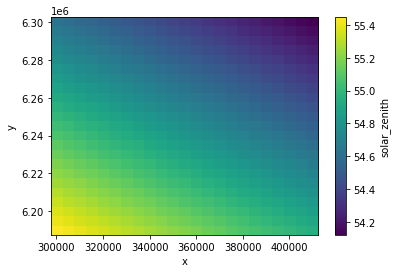

In [106]:
solar_za.plot.imshow();

In [107]:
crs = parsed.find('horizontal_cs_code').contents[0]

In [108]:
x, y = np.meshgrid(solar_za.x.values, solar_za.y.values)

In [109]:
from pyproj import Transformer

# get lat/lon coordinates
transformer = Transformer.from_crs(crs, "epsg:4326", always_xy=True)
lon, lat = transformer.transform(x, y)

In [110]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import get_sun
from astropy.coordinates import EarthLocation, AltAz

In [111]:
t = Time(ds.time.begin)
loc = EarthLocation(lat=lat*u.deg, lon=lon*u.deg)
f = AltAz(obstime=t, location=loc)
sun_altaz = get_sun(t).transform_to(f)

In [112]:
sun_za = (90- sun_altaz.alt/u.deg)
sun_az = sun_altaz.az/u.deg

In [113]:
sun_za = xr.DataArray(sun_za, coords=solar_za.coords, dims=solar_za.dims)
sun_az = xr.DataArray(sun_az, coords=solar_az.coords, dims=solar_az.dims)

In [114]:
np.abs(solar_az-sun_az).max().values, np.abs(solar_za-sun_za).max().values

(array(0.05029062), array(0.01910696))

In [115]:
np.abs(solar_az-sun_az).mean().values, np.abs(solar_za-sun_za).mean().values

(array(0.01992339), array(0.00786859))

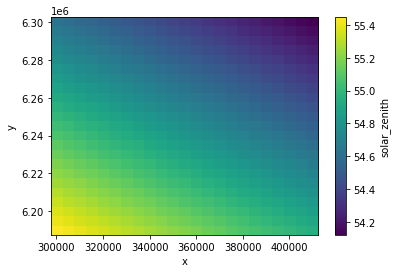

In [116]:
solar_za.plot.imshow();

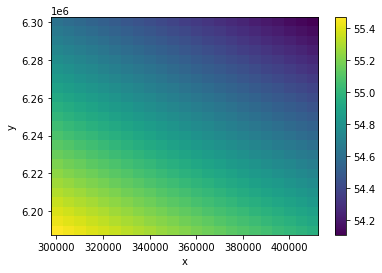

In [117]:
sun_za.plot.imshow();

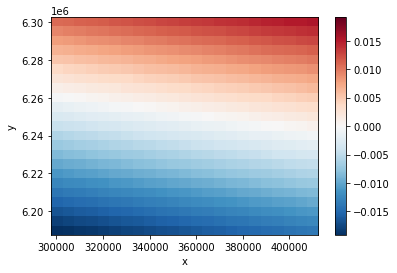

In [118]:
((solar_za-sun_za)).plot.imshow();

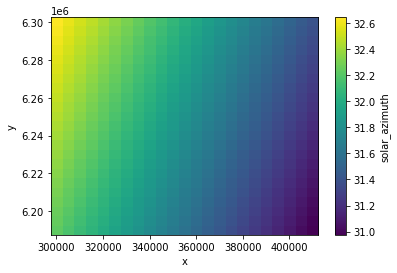

In [119]:
solar_az.plot.imshow();

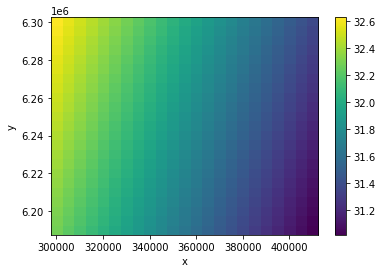

In [120]:
sun_az.plot.imshow();

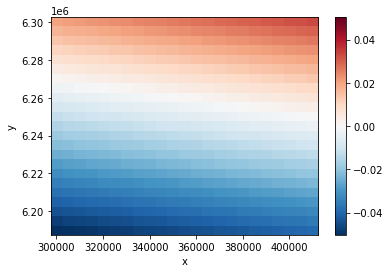

In [121]:
((solar_az-sun_az)).plot.imshow();

## Check BRDF factor over time

In [122]:
band_names = ['B03', 'B04','B08', 'B11', 'B12']

brdfs = {}
for band_name in band_names:
    brdfs[band_name] = []
    
for ds in dss:
    xml = get_xml(ds)
    parsed = parse_xml(xml)
    for band_name in band_names:
        brdf_flood = normalized_brdf(parsed, band_name, method = 'flood')
        brdf_flood = brdf_flood.expand_dims({'time':[ds.time.begin]})
        brdfs[band_name].append(brdf_flood)

In [123]:
brdf = None
for band_name in band_names:
    d = xr.concat(brdfs[band_name], dim='time')
    d = d.sortby('time')
    d = d.expand_dims({'band':[band_name]})
    if brdf is None: brdf = d
    else: brdf = xr.concat([brdf, d], dim='band')

brdf = brdf.to_dataset(dim='band')


In [124]:
brdf.coords['time'] = brdf.time.astype('<M8[ns]')

In [125]:
brdf = brdf.isel(time=brdf.B03.isnull().mean(dim=['x','y'])<0.4)

In [126]:
utime, time_idx, ntime = np.unique(brdf.time.values, return_index=True, return_counts=True)
brdf = brdf.isel(time=time_idx)

In [127]:
## identify left cover

left_idx = np.arange(len(brdf.time))[brdf.B03.isel(x=-1, y =-1).isnull().values]
right_idx = np.arange(len(brdf.time))[brdf.B03.isel(x=0, y =0).isnull().values]
left = brdf.isel(time=left_idx)
right = brdf.isel(time=right_idx).sel(time=brdf.isel(time=left_idx).time.values, method = 'nearest')
match = np.abs(left.time-right.time.values)<np.timedelta64(2,'D')
left = left.isel(time=match.values)
right= right.isel(time=match.values)
ratio = (left.to_array(dim='band')/right.to_array(dim='band').values).to_dataset(dim='band')

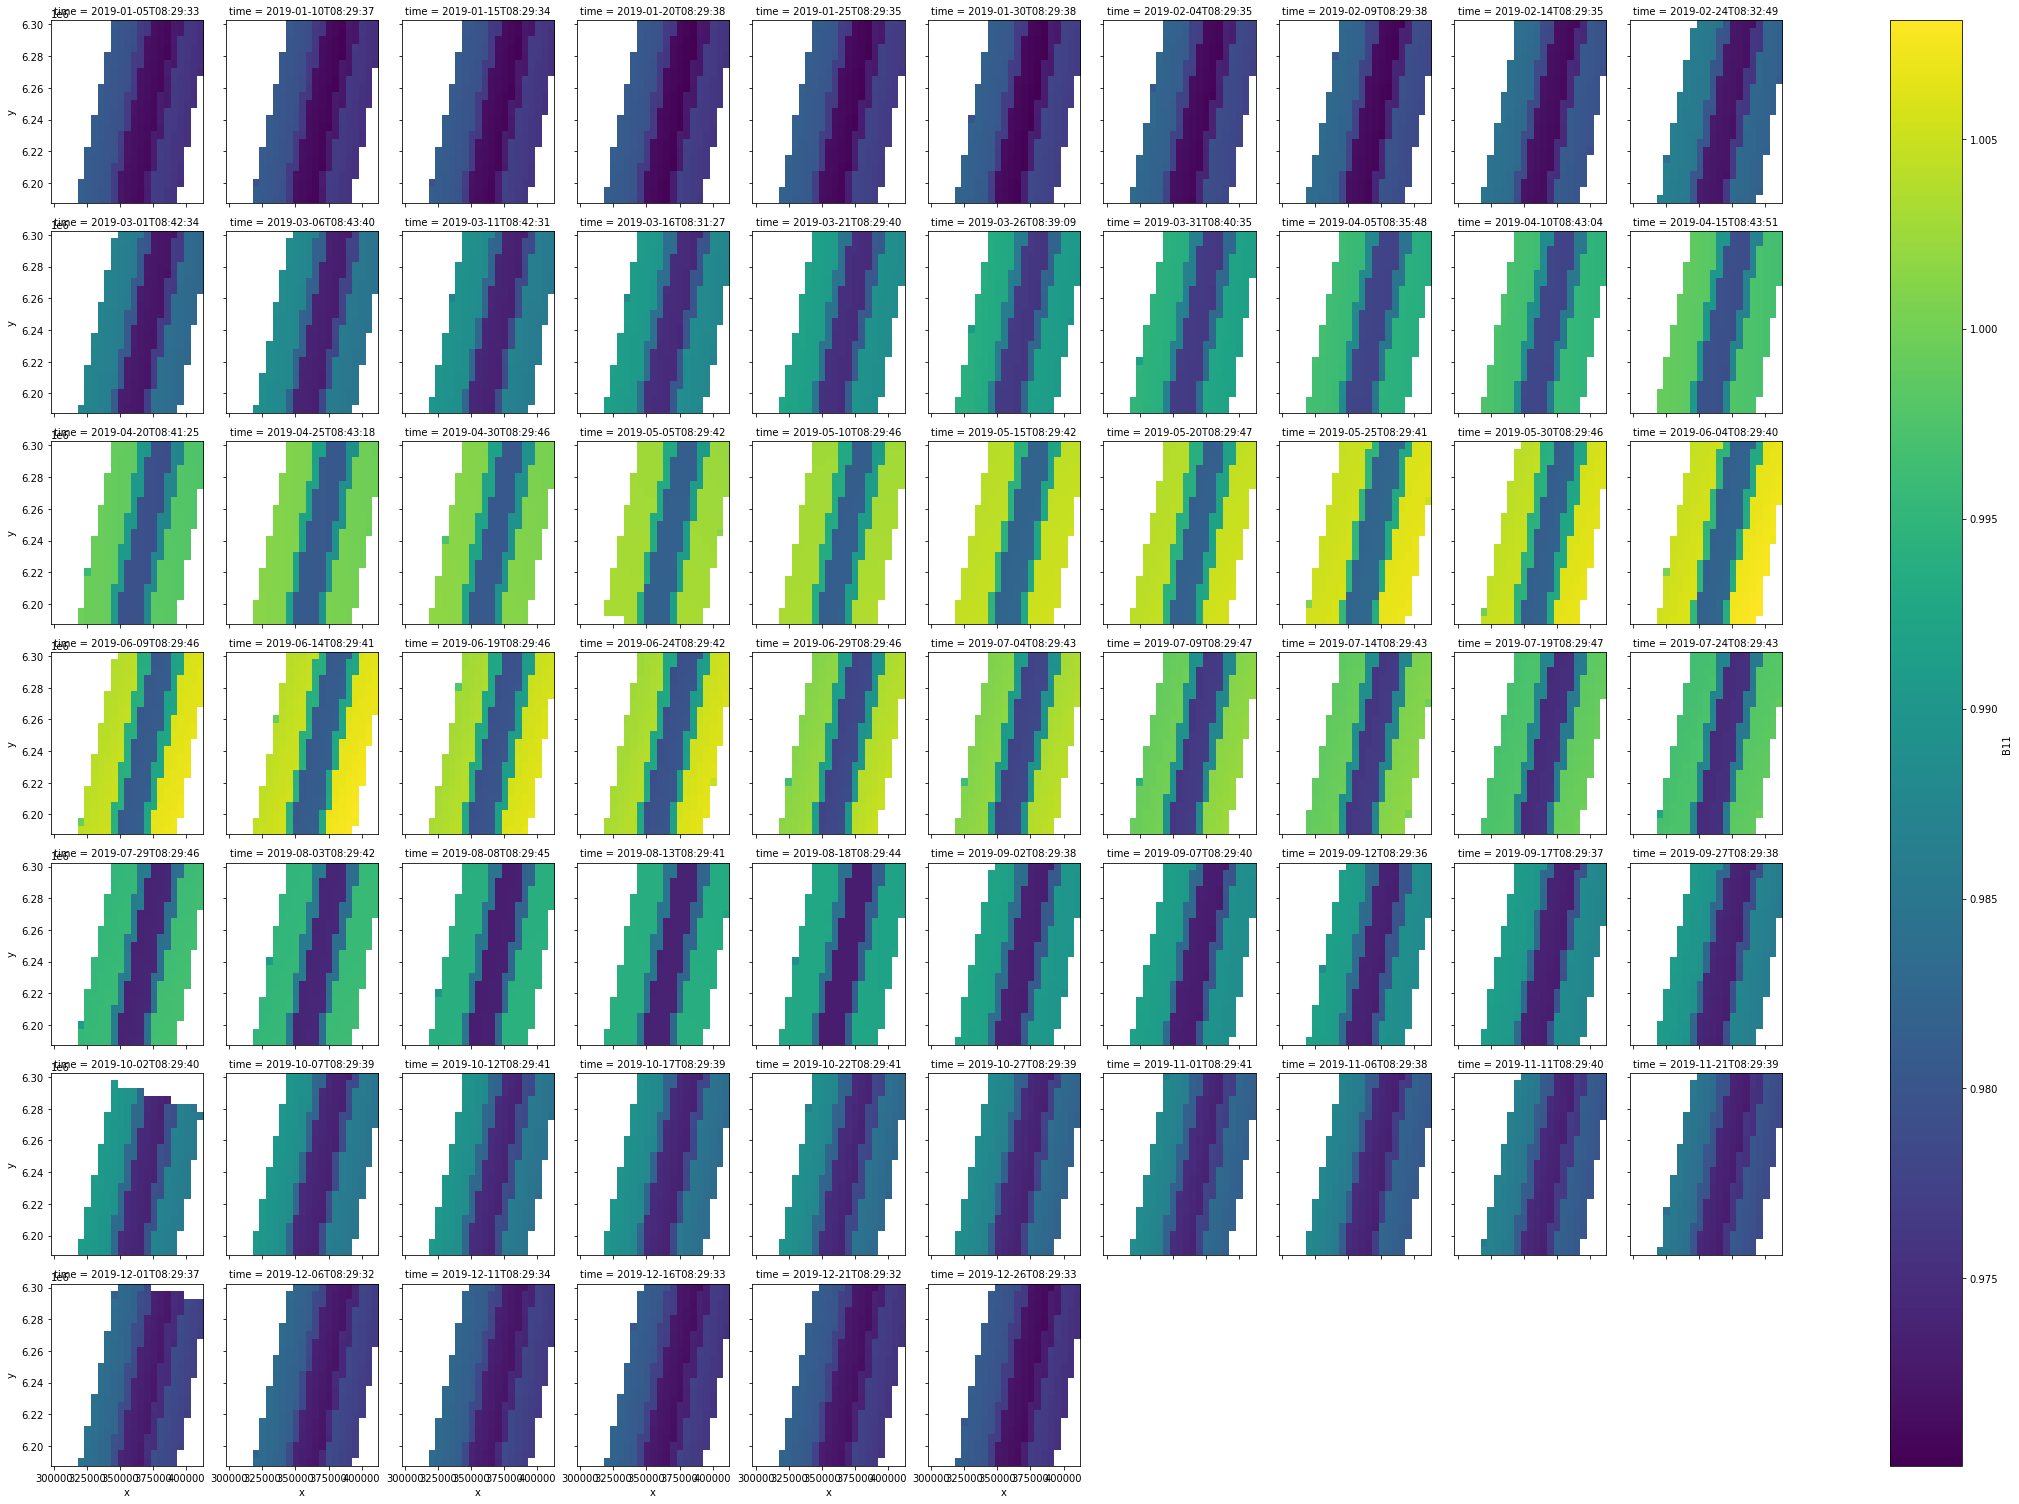

In [128]:
ratio.B11.plot.imshow(col='time', col_wrap=10);

## load data to check correction

In [129]:
crs = parsed.find('horizontal_cs_code').contents[0]

In [131]:
res = (brdf.y.values[1]-brdf.y.values[0], brdf.x.values[1]-brdf.x.values[0])
x, y = (brdf.x.values[0], brdf.x.values[-1]), (brdf.y.values[-1], brdf.y.values[0])
data = dc.load(product='s2_l2a', time='2019', datasets=dss, measurements=band_names+['SCL'],
                crs = crs, output_crs=crs, x = x, y = y, dask_chunks={}, resolution=(-10, 10), align=(5,5))
data = data.sel(time=brdf.time.values).sel(x=brdf.x.values).sel(y=brdf.y.values)

In [132]:
%%time
data = data.compute()

CPU times: user 59min 41s, sys: 9min 53s, total: 1h 9min 35s
Wall time: 10min 2s


In [133]:
# filter
pq_categories_s2=['vegetation','bare soils', 'unclassified']

flags_s2 = data.SCL.attrs['flags_definition']['qa']['values']
pq_mask = data.SCL.isin([int(k) for k,v in flags_s2.items() if v in pq_categories_s2])

In [134]:
clean_data = data[band_names].where(pq_mask)

### compare data before and after brdf

In [135]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.colors import LogNorm
from scipy.stats import pearsonr, spearmanr, kendalltau


In [136]:
clean_left = clean_data.sel(time=left.time)
clean_right = clean_data.sel(time=right.time)

In [137]:
regr = linear_model.LinearRegression(fit_intercept=False)

for var in band_names:
    print(var, clean_data[var].mean().values)
    arr1 = clean_left[var].values.flatten()
    arr2 = clean_right[var].values.flatten()
    valid = (~np.isnan(arr1)) & (~np.isnan(arr2))
    arr1, arr2 = arr1[valid], arr2[valid]
    regr.fit(arr2[:,np.newaxis], arr1[:,np.newaxis])
    # The coefficients
    print('Band:{0}, slope={1}, r2={2}'.format(var, regr.coef_[0][0],
                                                regr.score(arr2[:,np.newaxis], arr1[:,np.newaxis])))
        
    #print('Correlations:', pearsonr(arr1, arr2)[0], spearmanr(arr1, arr2)[0], kendalltau(arr1, arr2)[0])
    #rmse = np.sqrt(mean_squared_error(arr1, arr2))
    #print('RMSE:',rmse)

B03 823.022908438061
Band:B03, slope=0.8764231949938883, r2=0.6735304684534977
B04 920.3211490125673
Band:B04, slope=0.8986590483426171, r2=0.7857687926675158
B08 2314.1199281867143
Band:B08, slope=0.9198925439006607, r2=0.6874512602456038
B11 2308.66671454219
Band:B11, slope=0.9138613590380701, r2=0.8010664614801286
B12 1698.4930700179534
Band:B12, slope=0.9100118487467591, r2=0.8002098674046281


In [138]:
clean_brdf = clean_data/brdf
clean_brdf_left = clean_brdf.sel(time=left.time)
clean_brdf_right = clean_brdf.sel(time=right.time)
for var in band_names:
    print(var, clean_brdf[var].mean().values)
    arr1 = clean_brdf_left[var].values.flatten()
    arr2 = clean_brdf_right[var].values.flatten()
    valid = (~np.isnan(arr1)) & (~np.isnan(arr2))
    arr1, arr2 = arr1[valid], arr2[valid]
    regr.fit(arr2[:,np.newaxis], arr1[:,np.newaxis])
    # The coefficients
    print('Band:{0}, slope={1}, r2={2}'.format(var, regr.coef_[0][0],
                                                regr.score(arr2[:,np.newaxis], arr1[:,np.newaxis])))
    #print('Correlations:', pearsonr(arr1, arr2)[0], spearmanr(arr1, arr2)[0], kendalltau(arr1, arr2)[0])
    #rmse = np.sqrt(mean_squared_error(arr1, arr2))
    #print('RMSE:',rmse)

B03 835.075037749215
Band:B03, slope=0.909282662752719, r2=0.6909998810302962
B04 928.1130503109837
Band:B04, slope=0.9211928607711973, r2=0.7947861095453079
B08 2328.4389345937107
Band:B08, slope=0.9410100680985574, r2=0.7011158948963135
B11 2336.101875272282
Band:B11, slope=0.9316945900937531, r2=0.8021195843607434
B12 1720.1189640905652
Band:B12, slope=0.9290731867212625, r2=0.8016684287825225


In [139]:
#clean_ratio = (clean_left.to_array(dim='band')/clean_right.to_array(dim='band').data).to_dataset(dim='band')
#clean_ratio = clean_ratio.where(np.isfinite(clean_ratio))

In [140]:
#clean_ratio.B11.plot.imshow(col='time', col_wrap=10, vmin=0.9, vmax=1.1);

Band:B03, slope=0.8764231949938883, r2=0.6735304684534977


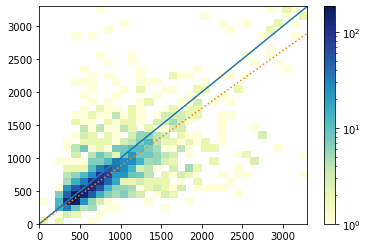

In [141]:
var = 'B03'
arr1 = clean_left[var].values.flatten()
arr2 = clean_right[var].values.flatten()
valid = (~np.isnan(arr1)) & (~np.isnan(arr2))
arr1, arr2 = arr1[valid], arr2[valid]
regr.fit(arr2[:,np.newaxis], arr1[:,np.newaxis])
# The coefficients
print('Band:{0}, slope={1}, r2={2}'.format(var, regr.coef_[0][0],
                                                regr.score(arr2[:,np.newaxis], arr1[:,np.newaxis])))
    
xedges=yedges=list(np.arange(0,np.max(arr1)/2,100))
X, Y = np.meshgrid(xedges, yedges)
cmname='YlGnBu'
hist, xe, ye= np.histogram2d(arr1, arr2, bins=(xedges, yedges))
plt.pcolor(X,Y,hist, cmap=cmname, norm=LogNorm(1, vmax=hist.max()))
plt.colorbar()
plt.plot(xedges,xedges);
plt.plot(xedges, regr.predict(np.array(xedges)[:,np.newaxis]), ':');

Band:B03, slope=0.909282662752719, r2=0.6909998810302962


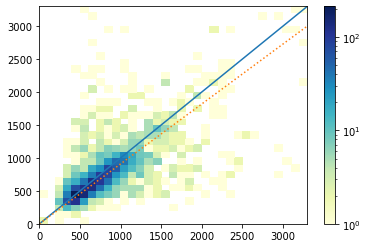

In [142]:
var = 'B03'
arr1 = clean_brdf_left[var].values.flatten()
arr2 = clean_brdf_right[var].values.flatten()
valid = (~np.isnan(arr1)) & (~np.isnan(arr2))
arr1, arr2 = arr1[valid], arr2[valid]
regr.fit(arr2[:,np.newaxis], arr1[:,np.newaxis])
# The coefficients
print('Band:{0}, slope={1}, r2={2}'.format(var, regr.coef_[0][0],
                                                regr.score(arr2[:,np.newaxis], arr1[:,np.newaxis])))

#xedges=yedges=list(np.arange(0,np.max(arr1),100))
#X, Y = np.meshgrid(xedges, yedges)
#cmname='YlGnBu'
hist, xe, ye= np.histogram2d(arr1, arr2, bins=(xedges, yedges))
plt.pcolor(X,Y,hist, cmap=cmname, norm=LogNorm(1, vmax=hist.max()))
plt.colorbar()
plt.plot(xedges,xedges);
plt.plot(xedges, regr.predict(np.array(xedges)[:,np.newaxis]), ':');

### fractional cover

In [143]:
s2_coeff = {'B03':[66, 0.8669], 'B04':[92, 0.8882], 'B08':[145, 0.8663], 'B11':[107, 0.9174], 'B12':[-7, 0.9399]}
for band in band_names:
    clean_data[band] = clean_data[band]*s2_coeff[band][1] + s2_coeff[band][0]

In [144]:
from fc.fractional_cover import compute_fractions

def compute_fc(input_da, regression_coefficients = {'green':[31, 1.0582],
              'red':[64, 0.9871],
              'nir':[120, 1.0187],
              'swir1':[79, 0.9528],
              'swir2':[-42, 0.9688]}):
    """
    Compute fractional cover from an input data array.
    
    Parameters
    ---------- 
    input_da: xr.DataArray
        A 3-dimensional dataArray with the first dimension being spectral bands
    
    regression_coefficients: dict, optional
        A dictionary containing linear regression coefficients to transform the input spectral bands
        e.g. {'green':[31, 1.0582],
              'red':[64, 0.9871],
              'nir':[120, 1.0187],
              'swir1':[79, 0.9528],
              'swir2':[-42, 0.9688]}

    Returns
    -------
    A 3-dimensional xr.DataArray with the first dimension containing the FC components.  
    """
    # prepare input data
    is_valid_array= (input_da >0).all(dim=input_da.dims[0])
    input_da = input_da.where(is_valid_array, 0)
    # define output coordinates
    output_coords = {'variable': ['PV', 'NPV', 'BS', 'UE']}
    output_dims = ['variable']
    for dim in input_da.dims[1:]:
        output_coords[dim] = input_da.coords[dim]
        output_dims.append(dim)
    # calculate FC
    output = compute_fractions(input_da, regression_coefficients = regression_coefficients)
    # nodata value is -1
    return xr.DataArray(output, coords=output_coords, dims=output_dims).where(is_valid_array, -1)

In [145]:
fc = clean_data.to_array(dim='band').groupby('time').apply(compute_fc).to_dataset(dim='variable')

In [146]:
fc = fc.where(fc>-1)
fc_left = fc.sel(time=left.time)
fc_right = fc.sel(time=right.time)

In [147]:
ratio_fc = (fc_left.to_array(dim='band')/fc_right.to_array(dim='band').values).to_dataset(dim='band')

In [148]:
ratio_fc = ratio_fc.where(np.isfinite(ratio_fc))

In [149]:
#ratio_fc.PV.plot.imshow(col='time', col_wrap=10, vmin=0.9, vmax=1.1);

In [150]:
#fc_left[['BS','PV','NPV']].to_array().plot.imshow(col='time', col_wrap=10);

In [151]:
#fc_right[['BS','PV','NPV']].to_array().plot.imshow(col='time', col_wrap=10);

### corrected fc

In [152]:
fc_brdf = (clean_data/brdf).to_array(dim='band').groupby('time').apply(compute_fc).to_dataset(dim='variable')

In [153]:
fc_brdf = fc_brdf.where(fc_brdf>-1)
fc_brdf_left = fc_brdf.sel(time=left.time)
fc_brdf_right = fc_brdf.sel(time=right.time)

ratio_fc_brdf = (fc_brdf_left.to_array(dim='band')/fc_brdf_right.to_array(dim='band').values).to_dataset(dim='band')
ratio_fc_brdf = ratio_fc_brdf.where(np.isfinite(ratio_fc_brdf))

In [154]:
regr = linear_model.LinearRegression(fit_intercept=False) 
for var in ['PV', 'NPV', 'BS']:
    print(var, fc[var].mean().values, ratio_fc[var].mean().values, ratio_fc[var].std().values)
    arr1 = fc_left[var].values.flatten()
    arr2 = fc_right[var].values.flatten()
    valid = (~np.isnan(arr1)) & (~np.isnan(arr2))
    arr1, arr2 = arr1[valid], arr2[valid]
    regr.fit(arr2[:,np.newaxis], arr1[:,np.newaxis])
    # The coefficients
    print('Band:{0}, slope={1}, r2={2}'.format(band, regr.coef_[0][0],
                                                regr.score(arr2[:,np.newaxis], arr1[:,np.newaxis])))
    #print('Correlations:', pearsonr(arr1, arr2)[0], spearmanr(arr1, arr2)[0], kendalltau(arr1, arr2)[0])
    #rmse = np.sqrt(mean_squared_error(arr1, arr2))
    #print('RMSE:',rmse)

PV 40.92560143626571 1.0199753633363953 0.6659568468028779
Band:B12, slope=0.9556993106654965, r2=0.845310786427165
NPV 40.12330341113106 1.1543384722715713 1.4822620617032092
Band:B12, slope=0.9951012801117161, r2=0.46871005200729765
BS 17.707145421903054 1.3433648765491044 2.7240485396382645
Band:B12, slope=0.8516299829453979, r2=0.4110365886430697


In [155]:
for var in ['PV', 'NPV', 'BS']:
    print(var, fc_brdf[var].mean().values, ratio_fc_brdf[var].mean().values, ratio_fc_brdf[var].std().values)
    arr1 = fc_brdf_left[var].values.flatten()
    arr2 = fc_brdf_right[var].values.flatten()
    valid = (~np.isnan(arr1)) & (~np.isnan(arr2))
    arr1, arr2 = arr1[valid], arr2[valid]
    regr.fit(arr2[:,np.newaxis], arr1[:,np.newaxis])
    # The coefficients
    print('Band:{0}, slope={1}, r2={2}'.format(band, regr.coef_[0][0],
                                                regr.score(arr2[:,np.newaxis], arr1[:,np.newaxis])))
    #print('Correlations:', pearsonr(arr1, arr2)[0], spearmanr(arr1, arr2)[0], kendalltau(arr1, arr2)[0])
    #rmse = np.sqrt(mean_squared_error(arr1, arr2))
    #print('RMSE:',rmse)

PV 40.87447037701975 1.0278517738089963 0.6107434228131445
Band:B12, slope=0.9629361167722141, r2=0.8414242621089165
NPV 40.06635547576302 1.0958822837108857 0.8253565007514655
Band:B12, slope=0.9848785766418292, r2=0.5245297618230624
BS 17.819892280071812 1.3565004362590536 2.4409329613519937
Band:B12, slope=0.8672624171499848, r2=0.4023735362791254


Band:NPV, slope=0.9951012801117161, r2=0.46871005200729765


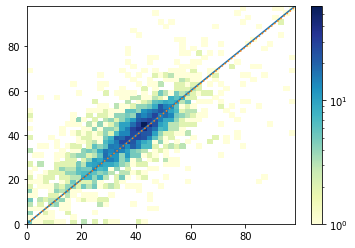

In [160]:
var = 'NPV'
arr1 = fc_left[var].values.flatten()
arr2 = fc_right[var].values.flatten()
valid = (~np.isnan(arr1)) & (~np.isnan(arr2))
arr1, arr2 = arr1[valid], arr2[valid]
regr.fit(arr2[:,np.newaxis], arr1[:,np.newaxis])
# The coefficients
print('Band:{0}, slope={1}, r2={2}'.format(var, regr.coef_[0][0],
                                                regr.score(arr2[:,np.newaxis], arr1[:,np.newaxis])))

xedges=yedges=list(np.arange(0,100,2))
X, Y = np.meshgrid(xedges, yedges)
cmname='YlGnBu'
hist, xe, ye= np.histogram2d(arr1, arr2, bins=(xedges, yedges))
plt.pcolor(X,Y,hist, cmap=cmname, norm=LogNorm(1, vmax=hist.max()))
plt.colorbar()
plt.plot(xedges,xedges);
plt.plot(xedges, regr.predict(np.array(xedges)[:,np.newaxis]), ':');

Band:NPV, slope=0.9848785766418292, r2=0.5245297618230624


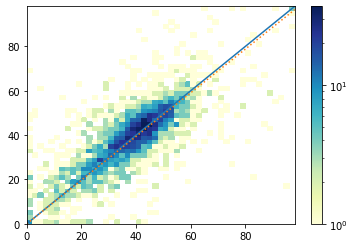

In [161]:
arr1 = fc_brdf_left[var].values.flatten()
arr2 = fc_brdf_right[var].values.flatten()
valid = (~np.isnan(arr1)) & (~np.isnan(arr2))
arr1, arr2 = arr1[valid], arr2[valid]
regr.fit(arr2[:,np.newaxis], arr1[:,np.newaxis])
# The coefficients
print('Band:{0}, slope={1}, r2={2}'.format(var, regr.coef_[0][0],
                                                regr.score(arr2[:,np.newaxis], arr1[:,np.newaxis])))

#xedges=yedges=list(np.arange(0,100,2))
#X, Y = np.meshgrid(xedges, yedges)
#cmname='YlGnBu'
hist, xe, ye= np.histogram2d(arr1, arr2, bins=(xedges, yedges))
plt.pcolor(X,Y,hist, cmap=cmname, norm=LogNorm(1, vmax=hist.max()))
plt.colorbar()
plt.plot(xedges,xedges);
plt.plot(xedges, regr.predict(np.array(xedges)[:,np.newaxis]), ':');